In [7]:
import polars as pl

def calculate_pic50(df: pl.DataFrame) -> pl.DataFrame:
    # 1. Define conversion factors to Molar (mol/L)
    unit_map = {
        "M": 1.0,
        "mol/L": 1.0,
        "mM": 1e-3,
        "uM": 1e-6,
        "microM": 1e-6,
        "umol/L": 1e-6,
        "nM": 1e-9,
        "nmol": 1e-9,
        "pM": 1e-12,
        "pmol/L": 1e-12,
    }

    return (
        # Only process IC50 rows
        df.filter(pl.col("standard_type") == "IC50")
        
        # Step 1: Extract exponents and base units
        .with_columns([
            pl.col("standard_value").cast(pl.Float64),
            
            # Extract 10^-5 or 10'5 parts
            pl.col("standard_units")
              .str.extract(r"10[\^']?(-?\d+)", 1)
              .cast(pl.Float64)
              .fill_null(0)
              .alias("exponent_prefix"),
            
            # Strip prefixes to find the base unit (e.g. "nM")
            pl.col("standard_units")
              .str.replace(r"10[\^']?-?\d+\s*", "")
              .str.strip_chars()
              .alias("base_unit")
        ])
        
        # Step 2: Map units and drop unmappable rows
        .with_columns([
            (pl.lit(10).pow(pl.col("exponent_prefix")) * pl.col("standard_value")).alias("clean_value"),
            
            # Use replace_strict: anything not in unit_map becomes null
            pl.col("base_unit").replace_strict(unit_map, default=None).alias("multiplier")
        ])
        
        # DROP rows that don't have a valid unit multiplier
        .filter(pl.col("multiplier").is_not_null())
        
        # Step 3: Final Math
        .with_columns([
            (pl.col("clean_value") * pl.col("multiplier")).alias("molar_conc")
        ])
        .with_columns([
            # pIC50 Calculation
            ( -pl.col("molar_conc").log10() ).alias("pIC50")
        ])
        
        # Remove helper columns for a clean output
        .drop(["exponent_prefix", "base_unit", "multiplier", "clean_value", "molar_conc"])
    )


In [8]:
import polars as pl
import pandas as pd
RAW_PATH = 'libs/datasets/chembl_human_activities.parquet'
df = pl.scan_parquet(RAW_PATH).collect()
df.head(5)

activity_id,assay_id,doc_id,record_id,molregno,standard_relation,standard_value,standard_units,standard_flag,standard_type,potential_duplicate,pchembl_value,bao_endpoint,uo_units,qudt_units,toid,upper_value,standard_upper_value,src_id,type,relation,value,units,text_value,standard_text_value,canonical_smiles,mw_freebase,alogp,hbd,hba,psa,heavy_atoms,confidence_score
i64,i64,i64,i64,i64,str,f64,str,i64,str,i64,f64,str,str,str,null,null,null,i64,str,str,f64,str,null,null,str,f64,f64,i64,i64,f64,i64,i64
340217,4,17841,191932,167941,""">""",10000.0,"""nM""",0,"""135""",0,null,"""BAO_0000179""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""135""",""">""",10000.0,"""nM""",null,null,"""Cc1cc(O)c2ccc(N)nc2n1""",175.19,1.23,2,4,72.03,13,4
161152,5,17430,585,556,"""=""",600000.0,"""nM""",1,"""CC50""",0,null,"""BAO_0000187""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""CC50""","""=""",0.0006,"""M""",null,null,"""O=[N+]([O-])O[C@H]1CO[C@H]2[C@…",236.14,-1.06,0,8,123.2,16,1
162404,5,17430,584,82983,"""=""",90000.0,"""nM""",1,"""CC50""",0,null,"""BAO_0000187""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""CC50""","""=""",0.00009,"""M""",null,null,"""O=c1[nH]c(=O)n([C@H]2C[C@H](O)…",246.19,-1.68,3,6,104.55,17,1
164804,5,17430,590,1633207,"""=""",340000.0,"""nM""",1,"""CC50""",0,null,"""BAO_0000187""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""CC50""","""=""",0.00034,"""M""",null,null,"""O=c1[nH]c(=O)n([C@H]2C[C@H](O)…",399.1,-1.0,2,8,136.69,20,1
166046,5,17430,578,1633675,"""=""",2400.0,"""nM""",1,"""CC50""",0,null,"""BAO_0000187""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""CC50""","""=""",0.0000024,"""M""",null,null,"""O=c1[nH]c(=O)n([C@H]2C[C@H](O[…",291.19,-1.47,2,8,136.69,20,1


In [9]:
df_with_pic50 = calculate_pic50(df)
df_with_pic50

activity_id,assay_id,doc_id,record_id,molregno,standard_relation,standard_value,standard_units,standard_flag,standard_type,potential_duplicate,pchembl_value,bao_endpoint,uo_units,qudt_units,toid,upper_value,standard_upper_value,src_id,type,relation,value,units,text_value,standard_text_value,canonical_smiles,mw_freebase,alogp,hbd,hba,psa,heavy_atoms,confidence_score,pIC50
i64,i64,i64,i64,i64,str,f64,str,i64,str,i64,f64,str,str,str,null,null,null,i64,str,str,f64,str,null,null,str,f64,f64,i64,i64,f64,i64,i64,f64
568109,7,13799,338777,286631,"""=""",0.8,"""nM""",1,"""IC50""",0,9.1,"""BAO_0000190""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""IC50""","""=""",0.8,"""nM""",null,null,"""CCC(CC)n1c(C)cc2c3c(N)nc(N)nc3…",283.38,3.42,2,5,82.75,21,1,9.09691
579288,7,13799,338768,49931,"""=""",8.8,"""nM""",1,"""IC50""",0,8.06,"""BAO_0000190""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""IC50""","""=""",8.8,"""nM""",null,null,"""CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc…",454.45,0.27,5,10,210.54,33,1,8.055517
865575,9,3801,76002,69954,"""=""",118000.0,"""nM""",1,"""IC50""",0,null,"""BAO_0000190""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""IC50""","""=""",118.0,"""uM""",null,null,"""COC(=O)C1C(C(=O)O)[C@@H]2CC[C@…",200.19,0.04,1,4,72.83,14,1,3.928118
865583,9,3801,75997,3133,"""=""",43000.0,"""nM""",1,"""IC50""",0,4.37,"""BAO_0000190""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""IC50""","""=""",43.0,"""uM""",null,null,"""O=C1OC(=O)C2C3CCC(O3)C12""",168.15,-0.14,0,4,52.6,12,1,4.366532
868123,9,3801,75999,68845,""">""",1e6,"""nM""",1,"""IC50""",0,null,"""BAO_0000190""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""IC50""",""">""",1000.0,"""uM""",null,null,"""CCCOC1OC(=O)[C@H]2[C@@H]1[C@@H…",212.24,1.09,0,4,44.76,15,1,3.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
313507,103223,14740,284792,1633560,"""=""",430.0,"""nM""",1,"""IC50""",0,6.37,"""BAO_0000190""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""IC50""","""=""",0.43,"""uM""",null,null,"""Cn1cnn2c(=O)c3ncn([C@@H]4O[C@H…",478.3,-0.93,3,13,192.53,31,1,6.366532
315983,103223,14740,284790,1633561,"""=""",150.0,"""nM""",1,"""IC50""",0,6.82,"""BAO_0000190""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""IC50""","""=""",0.15,"""uM""",null,null,"""Cn1cnc2c(ncn2[C@@H]2O[C@H](COP…",454.34,0.79,3,11,158.16,28,1,6.823909
324646,103223,14740,284791,1633559,"""=""",6700.0,"""nM""",1,"""IC50""",0,5.17,"""BAO_0000190""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""IC50""","""=""",6.7,"""uM""",null,null,"""CO[C@@H]1[C@H](OP(C)(=O)O)[C@@…",492.32,-0.28,2,13,181.53,32,1,5.173925


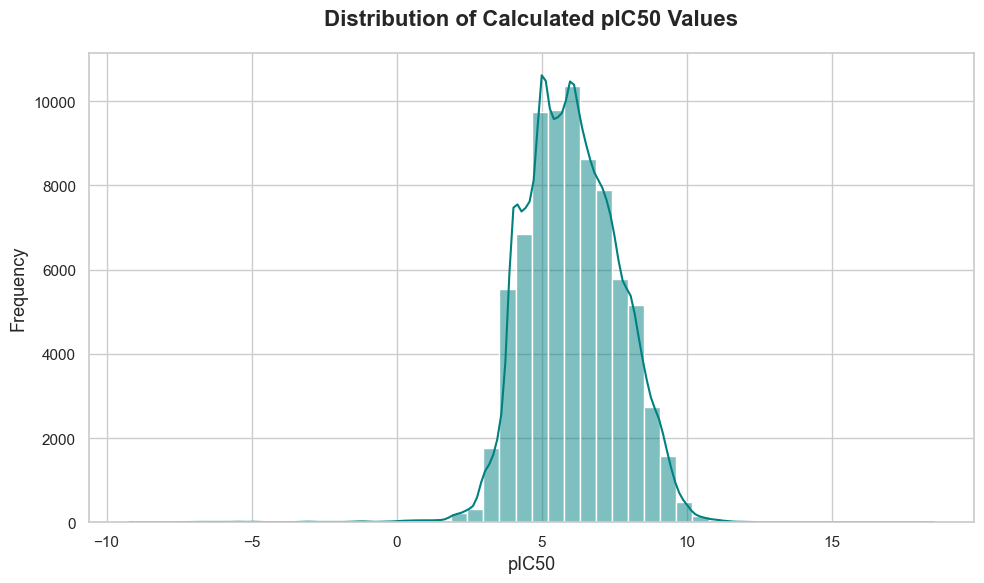

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

# 1. Prepare the data for plotting
# We filter out any non-finite values (NaN/Inf) that might have resulted from log(0)
plot_data = (
    df_with_pic50
    .filter(pl.col("pIC50").is_finite())
    .select("pIC50")
    .to_pandas()
)

# 2. Set the visual style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# 3. Create the Distribution Plot
sns.histplot(
    data=plot_data, 
    x="pIC50", 
    kde=True, 
    color="teal", 
    bins=50,
    edgecolor='white'
)

# 4. Add formatting and labels
plt.title("Distribution of Calculated pIC50 Values", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("pIC50", fontsize=13)
plt.ylabel("Frequency", fontsize=13)

# 5. Clean layout and save
plt.tight_layout()
plt.show() # Uncomment if running in a local environment

In [15]:
# from chembl_webresource_client.utils import utils
# import json
# 
# def get_description(smiles_example):
#     tab_example = utils.smiles2ctab(smiles_example)
#     descs = json.loads(utils.chemblDescriptors(tab_example))
#     return descs

In [62]:
# described = [get_description(smiles) for smiles in df_with_pic50['canonical_smiles'].head(5)]
# described

statistic,activity_id,assay_id,doc_id,record_id,molregno,standard_relation,standard_value,standard_units,standard_flag,standard_type,potential_duplicate,pchembl_value,bao_endpoint,uo_units,qudt_units,toid,upper_value,standard_upper_value,src_id,type,relation,value,units,text_value,standard_text_value,canonical_smiles,mw_freebase,alogp,hbd,hba,psa,heavy_atoms,confidence_score,pIC50
str,f64,f64,f64,f64,f64,str,f64,str,f64,str,f64,f64,str,str,str,f64,f64,f64,f64,str,str,f64,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",77329.0,77329.0,77329.0,77329.0,77329.0,"""77304""",77329.0,"""77329""",77329.0,"""77329""",77329.0,63103.0,"""77329""","""77329""","""77329""",0.0,0.0,0.0,77329.0,"""77329""","""77308""",77329.0,"""74207""",0.0,0.0,"""77329""",77329.0,75629.0,75629.0,75629.0,75629.0,75629.0,77329.0,77329.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,"""25""",0.0,"""0""",0.0,"""0""",0.0,14226.0,"""0""","""0""","""0""",77329.0,77329.0,77329.0,0.0,"""0""","""21""",0.0,"""3122""",77329.0,77329.0,"""0""",0.0,1700.0,1700.0,1700.0,1700.0,1700.0,0.0,0.0
"""mean""",681515.966352,62718.854582,10335.196162,182012.085401,225660.014988,null,5.4051e13,null,1.0,null,0.027079,6.454599,null,null,null,null,null,null,1.0,null,null,1063.833693,null,null,null,null,440.998281,3.407395,2.131312,5.473535,93.883269,29.712055,5.340015,inf
"""std""",365139.530513,26102.403433,5454.058213,95824.573373,307936.700924,null,8.3626e15,null,0.0,null,0.162315,1.360031,null,null,null,null,null,null,0.0,null,null,15895.764915,null,null,null,null,228.710007,2.084287,1.85707,2.601162,52.973608,10.383577,3.271713,NaN
"""min""",31863.0,7.0,15.0,260.0,154.0,"""<""",0.0,"""nM""",1.0,"""IC50""",0.0,3.72,"""BAO_0000190""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1.0,"""-Log IC50""","""<""",-9.89,"""M""",null,null,"""Br.Br.Br.Br.C#CCNCCCNCCCNCCCNC…",60.1,-9.39,0.0,0.0,0.0,4.0,1.0,-9.21
"""25%""",367389.0,44687.0,5224.0,106788.0,84827.0,null,65.0,null,1.0,null,0.0,5.4,null,null,null,null,null,null,1.0,null,null,1.0,null,null,null,null,321.76,2.28,1.0,4.0,59.14,22.0,1.0,5.0
"""50%""",674186.0,65829.0,11744.0,183035.0,158129.0,null,1000.0,null,1.0,null,0.0,6.34,null,null,null,null,null,null,1.0,null,null,8.6,null,null,null,null,403.72,3.52,2.0,5.0,83.45,28.0,8.0,6.0
"""75%""",1.007916e6,85879.0,15332.0,261480.0,235511.0,null,10000.0,null,1.0,null,0.0,7.4,null,null,null,null,null,null,1.0,null,null,77.0,null,null,null,null,498.63,4.66,3.0,7.0,113.91,35.0,8.0,7.187087
"""max""",1.308761e6,103223.0,17861.0,350986.0,2.882632e6,"""~""",1.6218e18,"""nM""",1.0,"""IC50""",1.0,11.0,"""BAO_0000190""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1.0,"""pIC50""","""~~""",2e6,"""uM l-1""",null,null,"""c1ncn2c1C(NC1CCCC1)NN=C2NC1CCC…",4767.56,18.09,15.0,26.0,445.62,72.0,9.0,inf


In [ ]:
df_with_pic50.describe()

In [63]:
import polars as pl
import numpy as np

def preprocess_for_gnn(df):
    # 1. Drop rows where pIC50 is Infinite or Null (The NaN culprit)
    df = df.filter(
        pl.col("pIC50").is_not_null() & 
        pl.col("pIC50").is_finite()
    )

    # 2. Select and Cast Features
    # We use Log scaling for wide-range values like MW and PSA
    # and simple clipping/scaling for others.
    df = df.with_columns([
        # Log scaling MW (440 mean, 4767 max is too wide)
        (pl.col("mw_freebase").log1p() / 10).alias("mw_freebase"),
        
        # AlogP can be negative, so we just scale it
        (pl.col("alogp") / 10).alias("alogp"),
        
        # HBD/HBA are small integers, simple division works
        (pl.col("hbd") / 10).alias("hbd"),
        (pl.col("hba") / 20).alias("hba"),
        
        # PSA scaling (max is 445)
        (pl.col("psa") / 100).alias("psa"),
        
        # Ensure label is float32
        pl.col("pIC50").cast(pl.Float32)
    ])
    P_MIN, P_MAX = 2.0, 12.0
    df = df.filter(
    (pl.col("pIC50") >= P_MIN) & 
    (pl.col("pIC50") <= P_MAX)
    )
    df = df.drop_nulls(subset=['mw_freebase', 'alogp', 'hbd', 'hba', 'psa', 'pIC50'])

    # 3. Fill any remaining nulls in tabular columns with the median
    cols_to_fix = ['mw_freebase', 'alogp', 'hbd', 'hba', 'psa']
    for col in cols_to_fix:
        median_val = df.select(pl.col(col).median()).item()
        df = df.with_columns(pl.col(col).fill_null(median_val))

    return df

# Apply the preprocessing
df_with_pic50_ready = preprocess_for_gnn(df_with_pic50)

In [64]:
df_with_pic50_ready

activity_id,assay_id,doc_id,record_id,molregno,standard_relation,standard_value,standard_units,standard_flag,standard_type,potential_duplicate,pchembl_value,bao_endpoint,uo_units,qudt_units,toid,upper_value,standard_upper_value,src_id,type,relation,value,units,text_value,standard_text_value,canonical_smiles,mw_freebase,alogp,hbd,hba,psa,heavy_atoms,confidence_score,pIC50
i64,i64,i64,i64,i64,str,f64,str,i64,str,i64,f64,str,str,str,null,null,null,i64,str,str,f64,str,null,null,str,f64,f64,f64,f64,f64,i64,i64,f32
568109,7,13799,338777,286631,"""=""",0.8,"""nM""",1,"""IC50""",0,9.1,"""BAO_0000190""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""IC50""","""=""",0.8,"""nM""",null,null,"""CCC(CC)n1c(C)cc2c3c(N)nc(N)nc3…",0.565031,0.342,0.2,0.25,0.8275,21,1,9.09691
579288,7,13799,338768,49931,"""=""",8.8,"""nM""",1,"""IC50""",0,8.06,"""BAO_0000190""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""IC50""","""=""",8.8,"""nM""",null,null,"""CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc…",0.612129,0.027,0.5,0.5,2.1054,33,1,8.055517
865575,9,3801,76002,69954,"""=""",118000.0,"""nM""",1,"""IC50""",0,null,"""BAO_0000190""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""IC50""","""=""",118.0,"""uM""",null,null,"""COC(=O)C1C(C(=O)O)[C@@H]2CC[C@…",0.530425,0.004,0.1,0.2,0.7283,14,1,3.928118
865583,9,3801,75997,3133,"""=""",43000.0,"""nM""",1,"""IC50""",0,4.37,"""BAO_0000190""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""IC50""","""=""",43.0,"""uM""",null,null,"""O=C1OC(=O)C2C3CCC(O3)C12""",0.513079,-0.014,0.0,0.2,0.526,12,1,4.366531
868123,9,3801,75999,68845,""">""",1e6,"""nM""",1,"""IC50""",0,null,"""BAO_0000190""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""IC50""",""">""",1000.0,"""uM""",null,null,"""CCCOC1OC(=O)[C@H]2[C@@H]1[C@@H…",0.536242,0.109,0.0,0.2,0.4476,15,1,3.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
313507,103223,14740,284792,1633560,"""=""",430.0,"""nM""",1,"""IC50""",0,6.37,"""BAO_0000190""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""IC50""","""=""",0.43,"""uM""",null,null,"""Cn1cnn2c(=O)c3ncn([C@@H]4O[C@H…",0.617233,-0.093,0.3,0.65,1.9253,31,1,6.366531
315983,103223,14740,284790,1633561,"""=""",150.0,"""nM""",1,"""IC50""",0,6.82,"""BAO_0000190""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""IC50""","""=""",0.15,"""uM""",null,null,"""Cn1cnc2c(ncn2[C@@H]2O[C@H](COP…",0.612104,0.079,0.3,0.55,1.5816,28,1,6.823909
324646,103223,14740,284791,1633559,"""=""",6700.0,"""nM""",1,"""IC50""",0,5.17,"""BAO_0000190""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1,"""IC50""","""=""",6.7,"""uM""",null,null,"""CO[C@@H]1[C@H](OP(C)(=O)O)[C@@…",0.620116,-0.028,0.2,0.65,1.8153,32,1,5.173925


In [65]:
print(df_with_pic50_ready.null_count())

shape: (1, 34)
┌─────────────┬──────────┬────────┬───────────┬───┬─────┬─────────────┬──────────────────┬───────┐
│ activity_id ┆ assay_id ┆ doc_id ┆ record_id ┆ … ┆ psa ┆ heavy_atoms ┆ confidence_score ┆ pIC50 │
│ ---         ┆ ---      ┆ ---    ┆ ---       ┆   ┆ --- ┆ ---         ┆ ---              ┆ ---   │
│ u32         ┆ u32      ┆ u32    ┆ u32       ┆   ┆ u32 ┆ u32         ┆ u32              ┆ u32   │
╞═════════════╪══════════╪════════╪═══════════╪═══╪═════╪═════════════╪══════════════════╪═══════╡
│ 0           ┆ 0        ┆ 0      ┆ 0         ┆ … ┆ 0   ┆ 0           ┆ 0                ┆ 0     │
└─────────────┴──────────┴────────┴───────────┴───┴─────┴─────────────┴──────────────────┴───────┘


In [66]:
df_with_pic50_ready.describe()

statistic,activity_id,assay_id,doc_id,record_id,molregno,standard_relation,standard_value,standard_units,standard_flag,standard_type,potential_duplicate,pchembl_value,bao_endpoint,uo_units,qudt_units,toid,upper_value,standard_upper_value,src_id,type,relation,value,units,text_value,standard_text_value,canonical_smiles,mw_freebase,alogp,hbd,hba,psa,heavy_atoms,confidence_score,pIC50
str,f64,f64,f64,f64,f64,str,f64,str,f64,str,f64,f64,str,str,str,f64,f64,f64,f64,str,str,f64,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",75293.0,75293.0,75293.0,75293.0,75293.0,"""75270""",75293.0,"""75293""",75293.0,"""75293""",75293.0,61889.0,"""75293""","""75293""","""75293""",0.0,0.0,0.0,75293.0,"""75293""","""75274""",75293.0,"""72503""",0.0,0.0,"""75293""",75293.0,75293.0,75293.0,75293.0,75293.0,75293.0,75293.0,75293.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,"""23""",0.0,"""0""",0.0,"""0""",0.0,13404.0,"""0""","""0""","""0""",75293.0,75293.0,75293.0,0.0,"""0""","""19""",0.0,"""2790""",75293.0,75293.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",681494.982575,62750.281832,10298.869961,181572.598953,216780.594956,null,55002.934753,null,1.0,null,0.027453,6.450145,null,null,null,null,null,null,1.0,null,null,1014.300826,null,null,null,null,0.598807,0.341351,0.213228,0.27377,0.939207,29.739963,5.353207,6.097208
"""std""",363916.970271,26159.889509,5455.027535,95876.770637,289249.764663,null,402219.12959,null,0.0,null,0.1634,1.356494,null,null,null,null,null,null,0.0,null,null,14591.923933,null,null,null,null,0.034221,0.208272,0.185705,0.129967,0.529713,10.381825,3.26704,1.531326
"""min""",31863.0,7.0,15.0,260.0,154.0,"""<""",0.001,"""nM""",1.0,"""IC50""",0.0,3.72,"""BAO_0000190""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1.0,"""-Log IC50""","""<""",-9.89,"""M""",null,null,"""Br.Br.Br.Br.C#CCNCCCNCCCNCCCNC…",0.412778,-0.939,0.0,0.0,0.0,4.0,1.0,2.0
"""25%""",368791.0,44689.0,5210.0,106374.0,83980.0,null,65.0,null,1.0,null,0.0,5.4,null,null,null,null,null,null,1.0,null,null,0.97,null,null,null,null,0.577514,0.229,0.1,0.2,0.5931,22.0,1.0,5.0
"""50%""",673338.0,66405.0,11654.0,182228.0,156537.0,null,1000.0,null,1.0,null,0.0,6.33,null,null,null,null,null,null,1.0,null,null,8.5,null,null,null,null,0.599772,0.352,0.2,0.25,0.8347,28.0,8.0,6.0
"""75%""",1.006394e6,85981.0,15313.0,260871.0,234011.0,null,10000.0,null,1.0,null,0.0,7.4,null,null,null,null,null,null,1.0,null,null,75.0,null,null,null,null,0.620177,0.467,0.3,0.35,1.1391,35.0,8.0,7.187087
"""max""",1.308761e6,103223.0,17861.0,350986.0,2.882632e6,"""~""",1e7,"""nM""",1.0,"""IC50""",1.0,11.0,"""BAO_0000190""","""UO_0000065""","""http://www.openphacts.org/unit…",null,null,null,1.0,"""pIC50""","""~~""",2e6,"""uM l-1""",null,null,"""c1ncn2c1C(NC1CCCC1)NN=C2NC1CCC…",0.690787,1.809,1.5,1.3,4.4562,72.0,9.0,12.0


In [67]:
# Log your hyperparameters
params = {
    "learning_rate": 0.001,
    "batch_size": 32,
    "hidden_dim": 64,
    "architecture": "GCN + MLP Hybrid",
    "dataset": "ChEMBL36_IC50"
}

In [68]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class HybridMoleculeNet(nn.Module):
    def __init__(self, node_feature_dim, tabular_feature_dim, hidden_dim):
        super(HybridMoleculeNet, self).__init__()

        # --- Branch 1: Graph Neural Network (SMILES) ---
        self.conv1 = GCNConv(node_feature_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim * 2)
        self.conv3 = GCNConv(hidden_dim * 2, hidden_dim * 2)

        # --- Branch 2: Dense Network (Tabular Properties) ---
        self.tabular_mlp = nn.Sequential(
            nn.Linear(tabular_feature_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )

        # --- Combined Head ---
        # (hidden_dim * 2 from GNN) + (32 from MLP)
        self.fc_combined = nn.Sequential(
            nn.Linear((hidden_dim * 2) + 32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1) # Output for IC50 prediction
        )

    def forward(self, data):
        # 1. Process Graph
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        graph_vector = global_mean_pool(x, batch) 
    
        # 2. Process Tabular Data
        # Ensure shape is [Batch, Features] by removing the middle dimension
        tab_input = data.tabular.view(graph_vector.size(0), -1) 
        tab_vector = self.tabular_mlp(tab_input)
    
        # 3. Combine
        combined = torch.cat([graph_vector, tab_vector], dim=1)
        return self.fc_combined(combined)

In [69]:
import torch
from torch_geometric.data import Data
from rdkit import Chem

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol: 
        return None

    # Node features: Atomic Number (simplest approach)
    # For better results, include chirality, hybridization, etc.
    nodes = []
    for atom in mol.GetAtoms():
        nodes.append([atom.GetAtomicNum()]) 
    x = torch.tensor(nodes, dtype=torch.float)

    # Edge index: Bond connectivity
    edges = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edges.append([i, j])
        edges.append([j, i]) # GNNs usually expect undirected graphs
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return x, edge_index

In [70]:
from torch.utils.data import Dataset

class ChEMBLDataset(Dataset):
    def __init__(self, df):
        self.smiles = df['canonical_smiles'].to_numpy()
        # Select our tabular columns
        self.tabular_feats = df[['mw_freebase', 'alogp', 'hbd', 'hba', 'psa']].to_numpy().astype('float32')
        # Convert IC50 (nM) to pIC50
        self.labels = torch.tensor(df['pIC50'].to_numpy(), dtype=torch.float)

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        # 1. Get Graph data
        x, edge_index = smiles_to_graph(self.smiles[idx])

        # 2. Get Tabular data
        tab_data = torch.tensor(self.tabular_feats[idx], dtype=torch.float)

        # 3. Combine into a PyG Data object
        # We store the tabular data inside the Data object so the DataLoader handles it
        data = Data(x=x, edge_index=edge_index, y=self.labels[idx])
        data.tabular = tab_data.unsqueeze(0) # Shape [1, num_features]

        return data

In [74]:
import neptune
from neptune.utils import stringify_unsupported
import tomli
with open("config.toml", "rb") as f:
    config = tomli.load(f)
    project = config['neptune']['project']
    api_token = config['neptune']['api_token']
    
run = neptune.init_run(
    project=project,
    api_token=api_token
)

run["parameters"] = stringify_unsupported(params)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/she3r3/warsztaty-ai/e/WAI-6


In [72]:
print(df_with_pic50['pIC50'].head(5))

shape: (5,)
Series: 'pIC50' [f64]
[
	9.09691
	8.055517
	3.928118
	4.366532
	3.0
]


In [77]:
from torch_geometric.loader import DataLoader

# Initialize
dataset = ChEMBLDataset(df_with_pic50_ready)
loader = DataLoader(dataset, batch_size=params["batch_size"], shuffle=True)

model = HybridMoleculeNet(node_feature_dim=1, tabular_feature_dim=5,hidden_dim=params['hidden_dim'])
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
criterion = torch.nn.MSELoss()

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'running on {device_name}')
for epoch in range(100):
    model.train()
    epoch_loss = 0

    for batch_idx, batch in enumerate(loader):
        # Move batch data to the same device as the model
        batch = batch.to(device)
        
        optimizer.zero_grad()
        output = model(batch)
        
        # Flatten both to [batch_size] to ensure correct MSE calculation
        loss = criterion(output.view(-1), batch.y.view(-1))
        
        # Check for NaN before stepping (prevents corrupting weights)
        if torch.isnan(loss):
            print(f"Skipping NaN loss at epoch {epoch}, batch {batch_idx}")
            continue

        loss.backward()
        
        # Clip gradients to prevent exploding gradients (NaN issues)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        # FIXED: Accumulate the loss value
        epoch_loss += loss.item()

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / len(loader)
    
    # Log to Neptune/Run
    run["training/epoch/loss"].append(avg_loss)

    print(f"Epoch {epoch} | Total Loss: {epoch_loss:.4f} | Avg Loss: {avg_loss:.4f}")

# 3. Save and log the final model artifact
torch.save(model.state_dict(), "hybrid_gnn_model.pt")
run["model_checkpoints/final_weight"].upload("hybrid_gnn_model.pt")

run.stop() # Close the connection

Epoch 0 | Total Loss: 6522.8755 | Avg Loss: 2.7722
Epoch 1 | Total Loss: 5741.5979 | Avg Loss: 2.4401
Epoch 2 | Total Loss: 5501.4667 | Avg Loss: 2.3381
Epoch 3 | Total Loss: 5342.1359 | Avg Loss: 2.2704
Epoch 4 | Total Loss: 5208.2501 | Avg Loss: 2.2135
Epoch 5 | Total Loss: 5108.1823 | Avg Loss: 2.1709
Epoch 6 | Total Loss: 5067.5424 | Avg Loss: 2.1537
Epoch 7 | Total Loss: 4985.4623 | Avg Loss: 2.1188
Epoch 8 | Total Loss: 4944.4885 | Avg Loss: 2.1014
Epoch 9 | Total Loss: 4913.9776 | Avg Loss: 2.0884
Epoch 10 | Total Loss: 4876.5355 | Avg Loss: 2.0725
Epoch 11 | Total Loss: 4851.5541 | Avg Loss: 2.0619
Epoch 12 | Total Loss: 4818.9711 | Avg Loss: 2.0480
Epoch 13 | Total Loss: 4803.5470 | Avg Loss: 2.0415
Epoch 14 | Total Loss: 4791.5590 | Avg Loss: 2.0364
Epoch 15 | Total Loss: 4775.6508 | Avg Loss: 2.0296
Epoch 16 | Total Loss: 4776.5301 | Avg Loss: 2.0300
Epoch 17 | Total Loss: 4763.9888 | Avg Loss: 2.0246


KeyboardInterrupt: 